# Currency Classifier 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/piyush/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = "../data/"

In [6]:
os.listdir(PATH)

['valid', 'models', 'tmp', 'train']

In [7]:
os.listdir(f'{PATH}valid')

['usd', 'inr']

In [8]:
files = os.listdir(f'{PATH}valid/inr')[:5]
files

['68. 1468159882_vmvd2c_indianrupee.jpg',
 '33. 28410470-indian-rupee-notes-and-coins.jpg',
 '184. variations-of-indian-rupee-picture-id89581384?s=612x612.jpg',
 '149. maxresdefault.jpg',
 '11. ntd_indian_currency_changing_colours4-640x359.jpg']

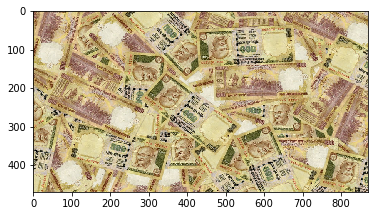

In [9]:
img = plt.imread(f'{PATH}valid/inr/{files[0]}')
plt.imshow(img);

In [10]:
img.shape

(470, 870, 3)

In [11]:
img[:4,:4]

array([[[114,  79,  47],
        [153, 116,  89],
        [150, 112,  89],
        [165, 127, 108]],

       [[143, 104,  73],
        [167, 127, 101],
        [171, 130, 108],
        [152, 109,  92]],

       [[122,  80,  55],
        [128,  86,  62],
        [161, 116,  97],
        [139,  93,  77]],

       [[164, 117,  97],
        [159, 112,  92],
        [168, 121, 103],
        [131,  82,  67]]], dtype=uint8)

In [12]:
sz = 64 #Resize every image to 64x64 so that our model trains faster

In [13]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 9) #0.01 is the learning rate, and 9 is the number of epochs

epoch      trn_loss   val_loss   accuracy        
    0      0.885262   0.47826    0.78125   
    1      0.739436   0.350107   0.84375         
    2      0.590344   0.311388   0.875           
    3      0.492914   0.30566    0.875           
    4      0.429397   0.317341   0.84375         
    5      0.386333   0.338182   0.859375        
    6      0.333844   0.316941   0.84375         
    7      0.295882   0.297352   0.875           
    8      0.26879    0.2877     0.890625        



[0.2876996397972107, 0.890625]

In [14]:
data.classes

['inr', 'usd']

In [15]:
log_preds = learn.predict()
log_preds.shape

(64, 2)

In [16]:
log_preds[:10]

array([[-0.00527, -5.24866],
       [-0.27979, -1.41036],
       [-0.24818, -1.51512],
       [-3.10733, -0.04575],
       [-0.0098 , -4.63054],
       [-0.18455, -1.78068],
       [-0.03178, -3.46477],
       [-0.0005 , -7.59808],
       [-0.00068, -7.29428],
       [-0.0055 , -5.20508]], dtype=float32)

In [17]:
preds = np.argmax(log_preds, axis=1)  
probs = np.exp(log_preds[:,1])        

In [18]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [19]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [20]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


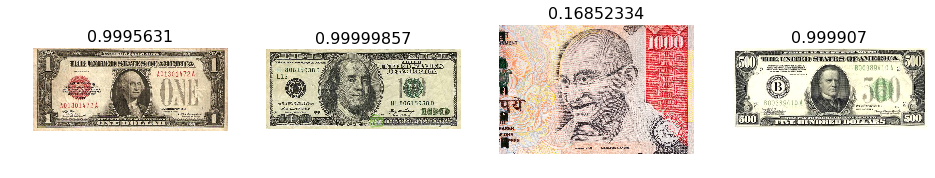

In [21]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


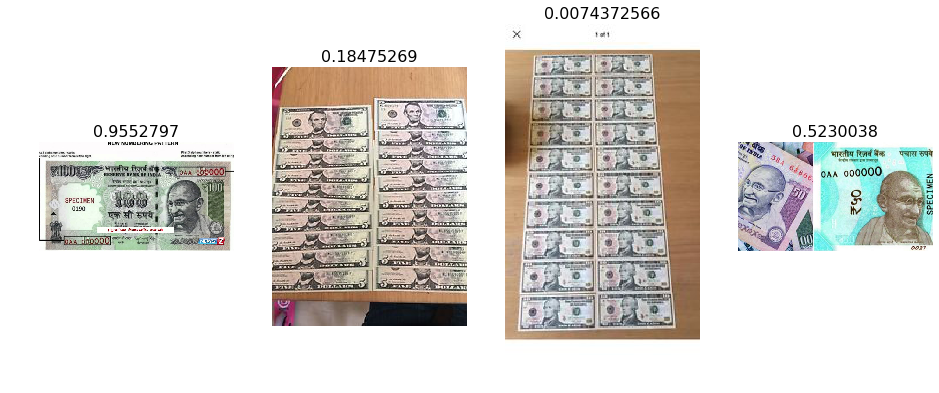

In [22]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [23]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct INR


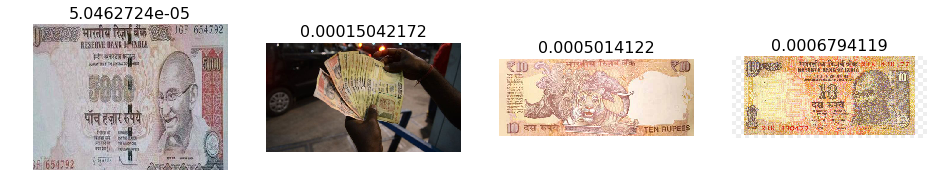

In [24]:
plot_val_with_title(most_by_correct(0, True), "Most correct INR")

Most correct USD


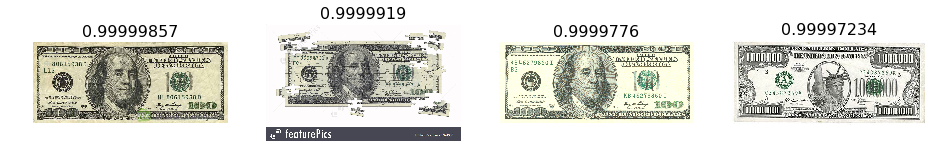

In [25]:
plot_val_with_title(most_by_correct(1, True), "Most correct USD")

Most incorrect INR


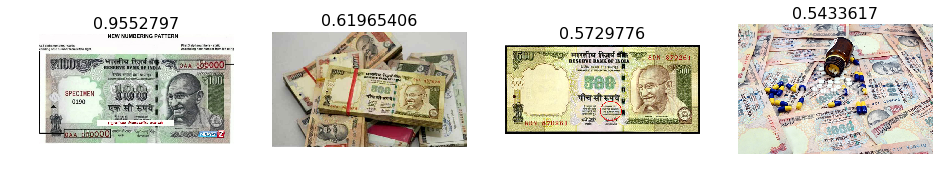

In [26]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect INR")

Most incorrect USD


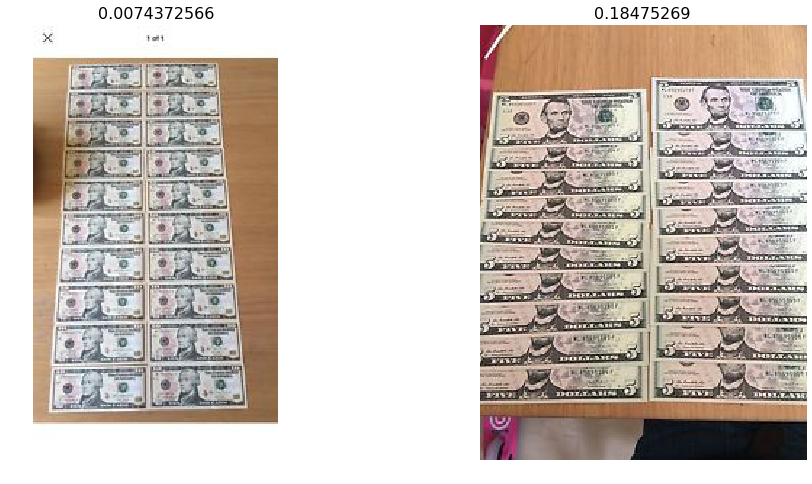

In [27]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect USD")

Most uncertain predictions


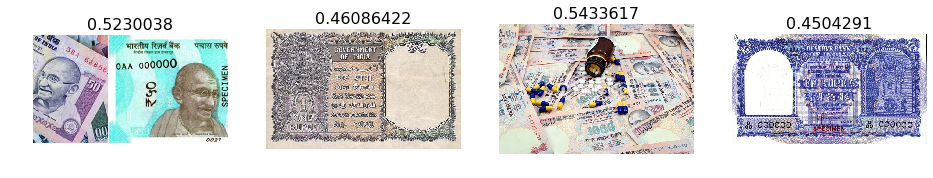

In [28]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [29]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [30]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy        
    0      0.917252   1.2799     0.765625  



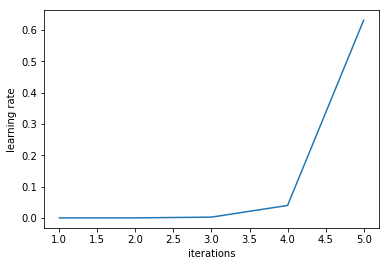

In [31]:
learn.sched.plot_lr()

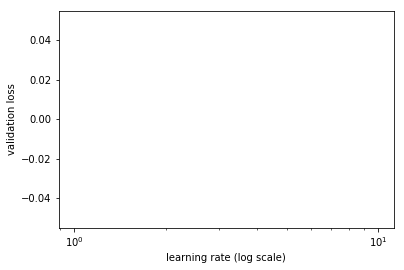

In [32]:
learn.sched.plot() #no plot because our dataset is too small

In [33]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [34]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [35]:
ims = np.stack([get_augs() for i in range(6)])

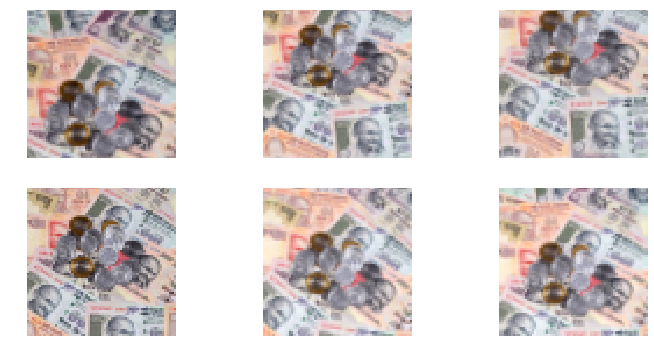

In [36]:
plots(ims, rows=2)

In [37]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [38]:
learn.fit(1e-2, 9)

epoch      trn_loss   val_loss   accuracy        
    0      0.826658   0.450501   0.828125  
    1      0.666116   0.326772   0.875           
    2      0.570004   0.272007   0.90625         
    3      0.501747   0.251856   0.890625        
    4      0.445538   0.239931   0.90625         
    5      0.398698   0.232883   0.90625         
    6      0.36356    0.232566   0.90625         
    7      0.332383   0.232413   0.890625        
    8      0.306692   0.230341   0.890625        



[0.23034076392650604, 0.890625]

In [39]:
learn.precompute=False

In [40]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.383136   0.232606   0.890625  
    1      0.333173   0.242042   0.90625                 
    2      0.333478   0.258744   0.890625                



[0.2587442398071289, 0.890625]

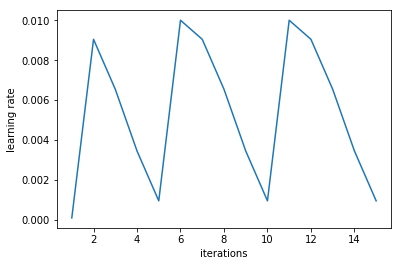

In [41]:
learn.sched.plot_lr()

In [42]:
learn.unfreeze()

In [43]:
lr=np.array([0.01/9,0.01/3,0.01])

In [44]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.564169   0.25924    0.859375  
    1      0.514034   0.255693   0.859375                
    2      0.433658   0.229132   0.890625                
    3      0.392138   0.254751   0.890625                
    4      0.340696   0.249652   0.90625                 
    5      0.298933   0.257856   0.90625                 
    6      0.282812   0.259295   0.90625                 



[0.2592950463294983, 0.90625]

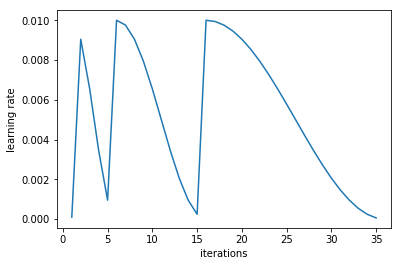

In [45]:
learn.sched.plot_lr()

In [46]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [47]:
accuracy_np(probs, y)

0.90625

In [48]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[29  3]
 [ 3 29]]


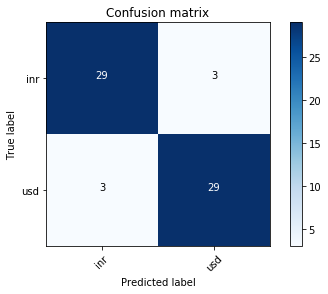

In [50]:
plot_confusion_matrix(cm, data.classes)

Most incorrect INR


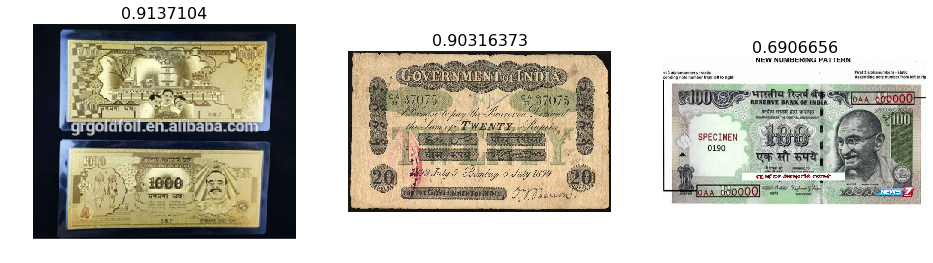

In [51]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect INR")

Most incorrect USD


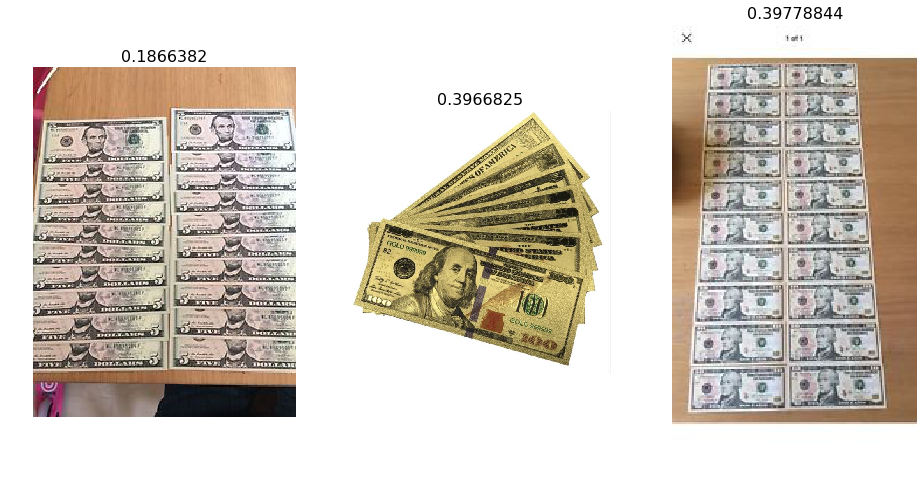

In [52]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect USD")